# Lab: Decision Trees for Classification

## Learning Objectives
By the end of this lab, you will be able to:
- Understand how decision trees partition the feature space
- Visualise decision boundaries without requiring graphviz
- Explore the effect of key hyperparameters (max_depth, min_samples_split, min_samples_leaf)
- Compare decision trees with KNN and logistic regression
- Use cross-validation with different metrics (accuracy, F1, precision, recall)
- Understand when different evaluation metrics matter

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)

## Part 1: Visualising Decision Boundaries

One of the key advantages of decision trees is their interpretability. While we can't use graphviz, we can visualize how decision trees partition the feature space by plotting decision boundaries.

### 1.1 Helper Function for Plotting Decision Boundaries

This function will help us visualize how different models divide the feature space.

In [2]:
def plot_decision_boundary(model, X, y, title="Decision Boundary", ax=None):
    """
    Plot the decision boundary of a classification model.
    
    Parameters:
    - model: fitted classifier
    - X: feature array (n_samples, 2)
    - y: labels
    - title: plot title
    - ax: matplotlib axis (optional)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a mesh to plot decision boundary
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                        edgecolors='black', s=50)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax)
    
    return ax

### 1.2 Decision Trees on Make_Moons Dataset

Let's start with a non-linearly separable dataset to see how decision trees handle complex boundaries.

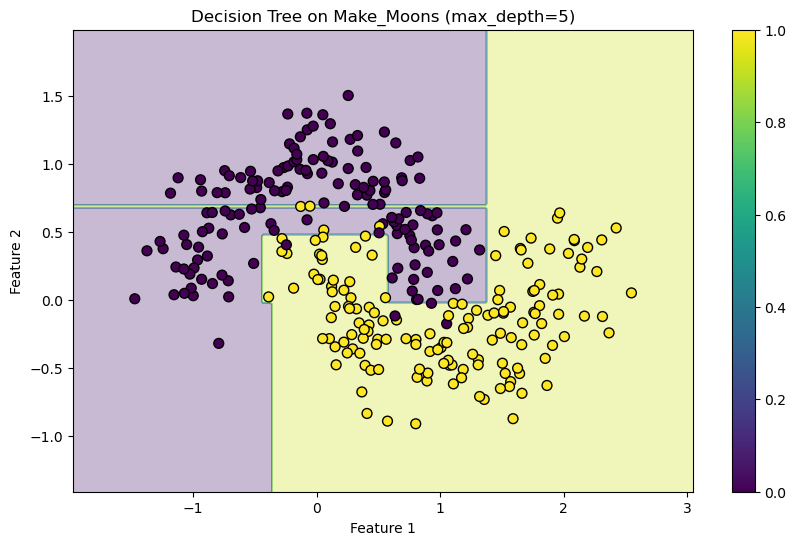

Training Accuracy: 0.983


In [3]:
# Generate make_moons dataset
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=42)

# Train a decision tree
tree_moons = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_moons.fit(X_moons, y_moons)

# Visualize
plot_decision_boundary(tree_moons, X_moons, y_moons, 
                      title="Decision Tree on Make_Moons (max_depth=5)")
plt.show()

print(f"Training Accuracy: {tree_moons.score(X_moons, y_moons):.3f}")

**Question**: Notice how the decision boundary consists of rectangular regions. Why do you think this is?

**Answer**: Decision trees split the feature space using axis-aligned (vertical or horizontal) cuts at specific feature values. At each node, the algorithm chooses the split that produces the purest child nodes. Purity measures how mixed the class labels are after the split. Because each split is based on a single feature threshold, the resulting decision boundaries are rectangular rather than curved or diagonal.

---

### 1.3 Decision Trees on Make_Blobs with 4 Classes

Now let's try a multi-class problem to see how decision trees handle more complex classification tasks.

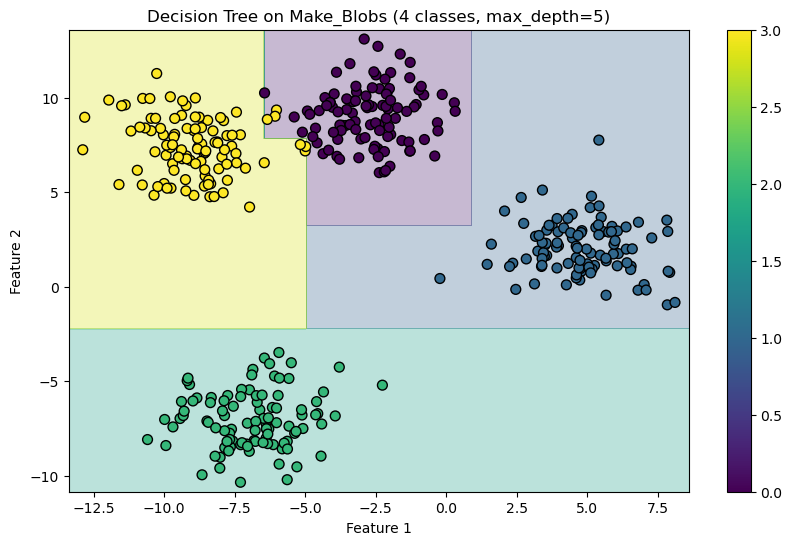

Training Accuracy: 0.993


In [4]:
# Generate make_blobs with 4 classes
X_blobs, y_blobs = make_blobs(n_samples=400, centers=4, n_features=2, 
                              cluster_std=1.5, random_state=42)

# Train a decision tree
tree_blobs = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_blobs.fit(X_blobs, y_blobs)

# Visualize
plot_decision_boundary(tree_blobs, X_blobs, y_blobs, 
                      title="Decision Tree on Make_Blobs (4 classes, max_depth=5)")
plt.show()

print(f"Training Accuracy: {tree_blobs.score(X_blobs, y_blobs):.3f}")

### 1.4 Exercise: Your Turn!

Create a decision tree for the make_moons dataset with `max_depth=2` and visualize the decision boundary. How does it compare to the tree with `max_depth=5`?

**Answer:**  
With max_depth=2, the decision tree produces a simple, less flexible decision boundary that cannot capture the nonlinear structure of the make_moons dataset, leading to underfitting and more misclassified points. In contrast, a deeper tree (max_depth=5) creates a more complex and jagged boundary that fits the data more closely, improving accuracy but increasing the risk of overfitting.

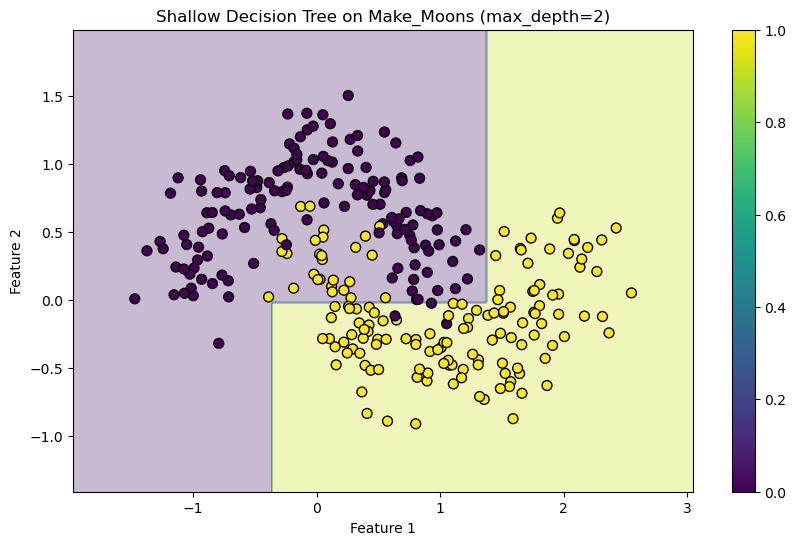

In [5]:
# Your code here
tree_shallow = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_shallow.fit(X_moons, y_moons)
plot_decision_boundary(tree_shallow, X_moons, y_moons, 
                      title="Shallow Decision Tree on Make_Moons (max_depth=2)")
plt.show()

## Part 2: Understanding Decision Tree Hyperparameters

Decision trees have several important hyperparameters that control their complexity and prevent overfitting:

- **max_depth**: Maximum depth of the tree
- **min_samples_split**: Minimum samples required to split an internal node
- **min_samples_leaf**: Minimum samples required at a leaf node

### 2.1 Effect of max_depth

Let's see how varying `max_depth` affects the model's complexity and decision boundary.

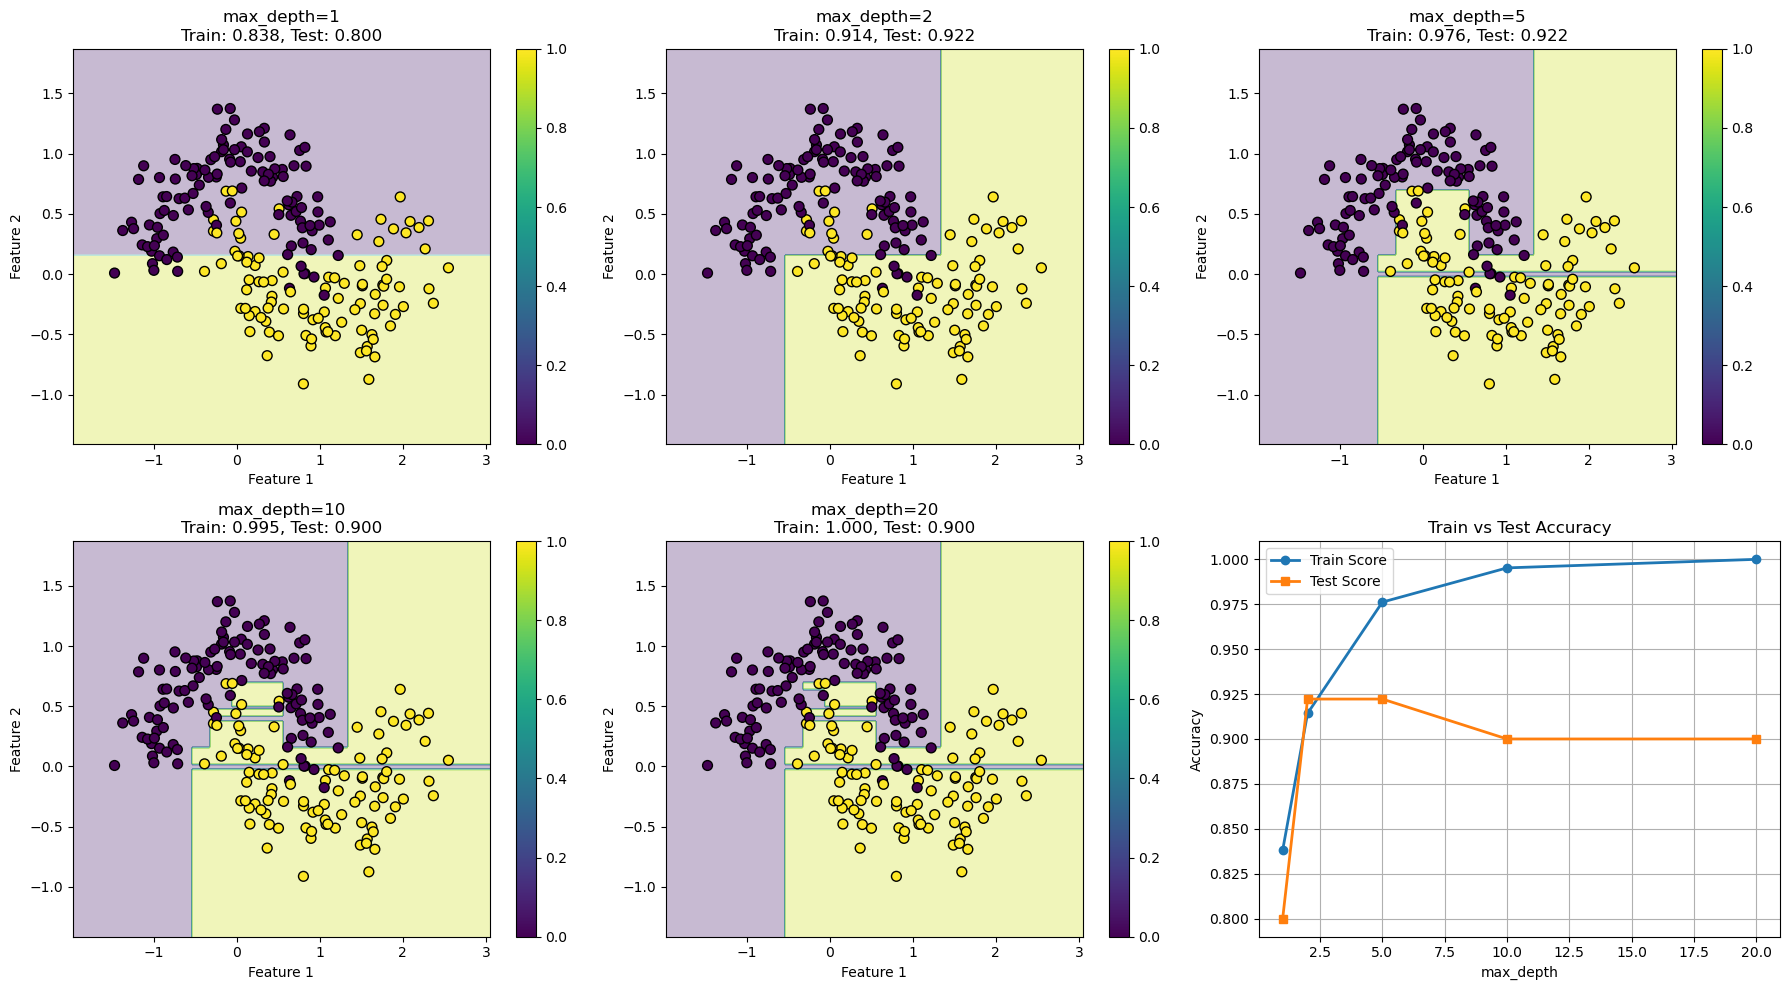

In [6]:
# Split data for proper evaluation
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, 
                                                    test_size=0.3, random_state=42)

# Try different max_depth values
depths = [1, 2, 5, 10, 20]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

train_scores = []
test_scores = []

for i, depth in enumerate(depths):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    plot_decision_boundary(tree, X_train, y_train, 
                          title=f"max_depth={depth}\nTrain: {train_score:.3f}, Test: {test_score:.3f}",
                          ax=axes[i])

# Plot train vs test scores
axes[-1].plot(depths, train_scores, marker='o', label='Train Score', linewidth=2)
axes[-1].plot(depths, test_scores, marker='s', label='Test Score', linewidth=2)
axes[-1].set_xlabel('max_depth')
axes[-1].set_ylabel('Accuracy')
axes[-1].set_title('Train vs Test Accuracy')
axes[-1].legend()
axes[-1].grid(True)

plt.tight_layout()
plt.show()

**Question**: At what depth does the model start to overfit? How can you tell?

---

### 2.2 Exercise: Exploring min_samples_split

The `min_samples_split` parameter controls how many samples are required to split an internal node. Higher values prevent the tree from learning very specific patterns.

Complete the code below to train trees with different `min_samples_split` values and compare their performance.

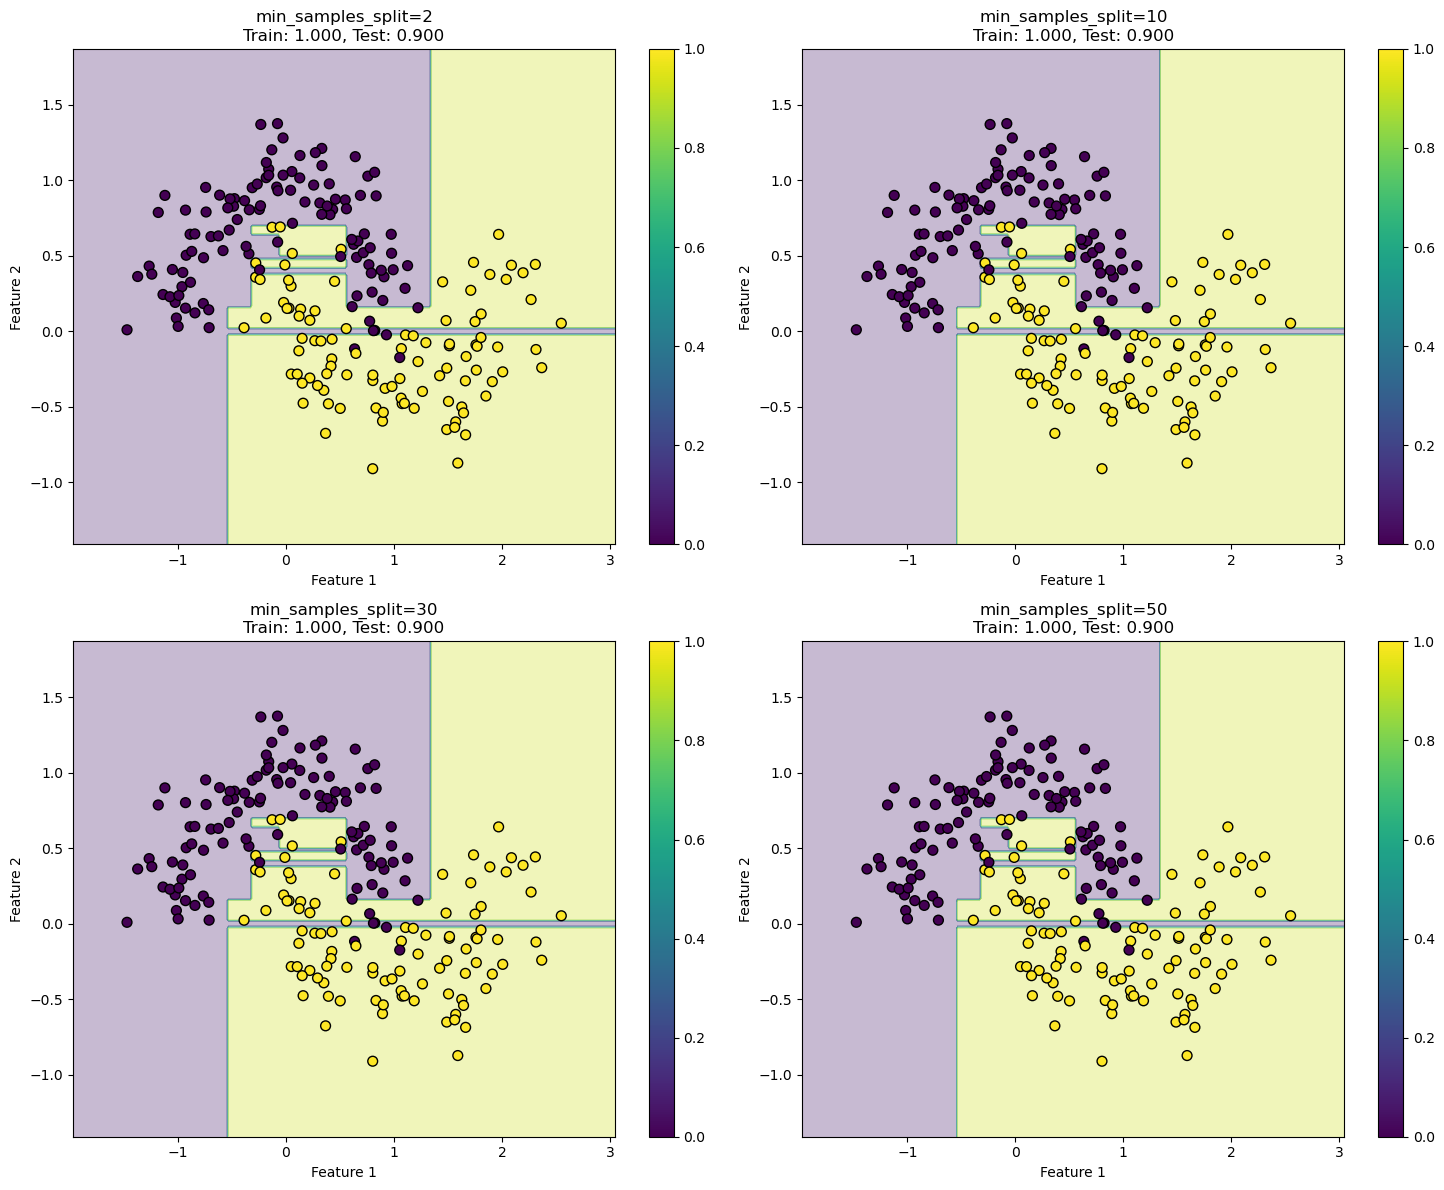

In [7]:
# Your code here
# Try min_samples_split values: [2, 10, 30, 50]
min_splits = [2, 10, 30, 50]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, min_split in enumerate(min_splits):
    # Create and train a decision tree with the current min_samples_split
    # Use max_depth=10 to allow the tree to grow
    
    
    # Calculate train and test scores
    
    
    # Plot the decision boundary
    plot_decision_boundary(tree, X_train, y_train,
                          title=f"min_samples_split={min_split}\nTrain: {train_score:.3f}, Test: {test_score:.3f}",
                          ax=axes[i])

plt.tight_layout()
plt.show()

### 2.3 Exercise: Exploring min_samples_leaf

Similarly, `min_samples_leaf` specifies the minimum number of samples required at each leaf node. This also helps prevent overfitting.

Train trees with `min_samples_leaf` values of [1, 5, 15, 30] and visualize the results.

In [8]:
# Your code here
min_leafs = [1, 5, 15, 30]



## Part 3: Feature Importance (Alternative to Tree Visualization)

Since we can't use graphviz, another way to interpret decision trees is through feature importance. This tells us which features the tree relies on most for making decisions.

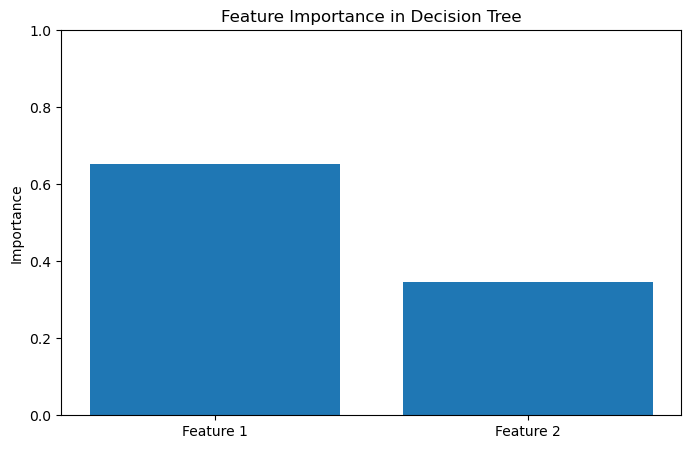

Feature 1 importance: 0.653
Feature 2 importance: 0.347


In [9]:
# Train a tree on the blobs dataset
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_blobs, y_blobs)

# Get feature importances
importances = tree.feature_importances_

# Plot
plt.figure(figsize=(8, 5))
plt.bar(['Feature 1', 'Feature 2'], importances)
plt.ylabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.ylim([0, 1])
plt.show()

print(f"Feature 1 importance: {importances[0]:.3f}")
print(f"Feature 2 importance: {importances[1]:.3f}")

## Part 3.1: Why Decision Trees Don't Need Feature Scaling

Unlike KNN and Logistic Regression, decision trees are **scale-invariant**. They only care about the relative ordering of values, not their magnitude. Let's demonstrate this!

In [10]:
# Create a dataset with features on very different scales
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Generate data where features have wildly different scales
np.random.seed(42)
X_unscaled = np.column_stack([
    np.random.normal(0, 1, 300),      # Feature 1: mean=0, std=1
    np.random.normal(0, 1000, 300)    # Feature 2: mean=0, std=1000 (1000x larger!)
])

# Create target based on both features
y_scale = ((X_unscaled[:, 0] > 0) & (X_unscaled[:, 1] > 0)).astype(int)

# Split the data
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(
    X_unscaled, y_scale, test_size=0.3, random_state=42
)

print("Feature scales (training set):")
print(f"  Feature 1 - Mean: {X_train_scale[:, 0].mean():.2f}, Std: {X_train_scale[:, 0].std():.2f}")
print(f"  Feature 2 - Mean: {X_train_scale[:, 1].mean():.2f}, Std: {X_train_scale[:, 1].std():.2f}")
print(f"\n  Feature 2 is ~1000x larger in scale!")

Feature scales (training set):
  Feature 1 - Mean: -0.04, Std: 1.03
  Feature 2 - Mean: 71.79, Std: 974.63

  Feature 2 is ~1000x larger in scale!


Now this code will scale the datamake a knn model, a logistic regression model and a decision tree model with the scaled data, and also models with the unscaled data

We should be able to see how scaling makes no difference to the Decision Tree while large differences to the others


Test Accuracy Comparison:
                          Accuracy
Decision Tree (Unscaled)     0.989
Decision Tree (Scaled)       0.989
KNN (Unscaled)               0.711
KNN (Scaled)                 0.956
Logistic Reg (Unscaled)      0.911
Logistic Reg (Scaled)        0.911


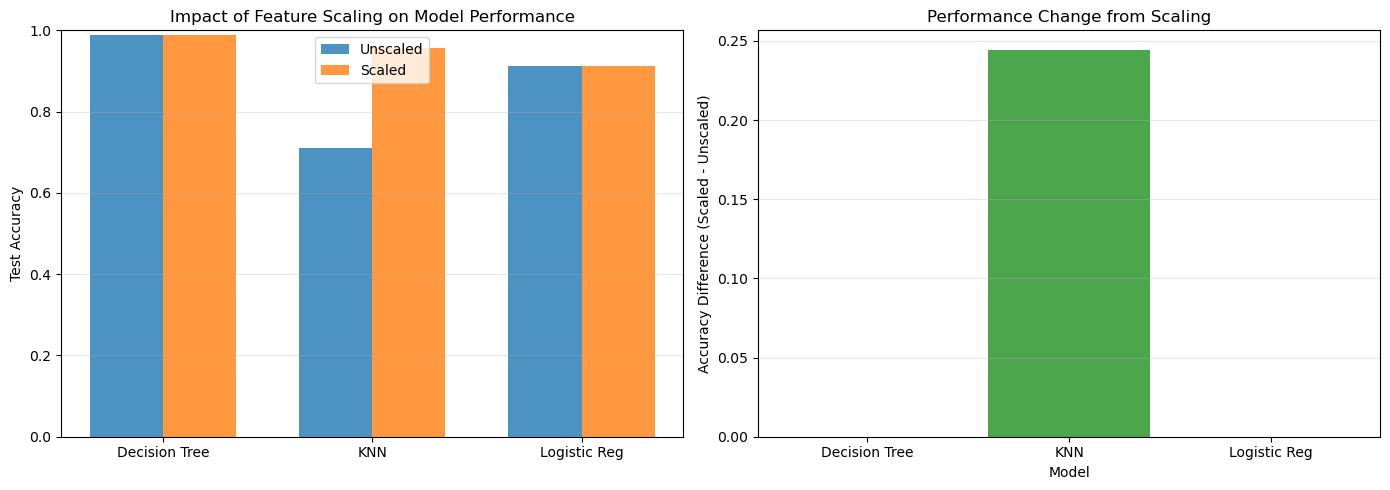


KEY INSIGHT:
Decision Tree: Scaling makes NO difference (same accuracy)
KNN & Logistic Regression: Scaling makes a HUGE difference!

Why? Decision trees only care about 'Is X > threshold?', not the
actual magnitude of X. KNN uses distances and LogReg uses magnitudes,
so they're sensitive to scale.


In [11]:
# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scale)
X_test_scaled = scaler.transform(X_test_scale)

# Train models on UNSCALED data
tree_unscaled = DecisionTreeClassifier(max_depth=5, random_state=42)
knn_unscaled = KNeighborsClassifier(n_neighbors=5)
logreg_unscaled = LogisticRegression(random_state=42)

tree_unscaled.fit(X_train_scale, y_train_scale)
knn_unscaled.fit(X_train_scale, y_train_scale)
logreg_unscaled.fit(X_train_scale, y_train_scale)

# Train models on SCALED data
tree_scaled = DecisionTreeClassifier(max_depth=5, random_state=42)
knn_scaled = KNeighborsClassifier(n_neighbors=5)
logreg_scaled = LogisticRegression(random_state=42)

tree_scaled.fit(X_train_scaled, y_train_scale)
knn_scaled.fit(X_train_scaled, y_train_scale)
logreg_scaled.fit(X_train_scaled, y_train_scale)

# Compare performance
results_scaling = pd.DataFrame({
    'Decision Tree (Unscaled)': [tree_unscaled.score(X_test_scale, y_test_scale)],
    'Decision Tree (Scaled)': [tree_scaled.score(X_test_scaled, y_test_scale)],
    'KNN (Unscaled)': [knn_unscaled.score(X_test_scale, y_test_scale)],
    'KNN (Scaled)': [knn_scaled.score(X_test_scaled, y_test_scale)],
    'Logistic Reg (Unscaled)': [logreg_unscaled.score(X_test_scale, y_test_scale)],
    'Logistic Reg (Scaled)': [logreg_scaled.score(X_test_scaled, y_test_scale)]
}, index=['Accuracy'])

print("\nTest Accuracy Comparison:")
print(results_scaling.T.round(3))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
models = ['Decision Tree', 'KNN', 'Logistic Reg']
unscaled_scores = [
    tree_unscaled.score(X_test_scale, y_test_scale),
    knn_unscaled.score(X_test_scale, y_test_scale),
    logreg_unscaled.score(X_test_scale, y_test_scale)
]
scaled_scores = [
    tree_scaled.score(X_test_scaled, y_test_scale),
    knn_scaled.score(X_test_scaled, y_test_scale),
    logreg_scaled.score(X_test_scaled, y_test_scale)
]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, unscaled_scores, width, label='Unscaled', alpha=0.8)
axes[0].bar(x + width/2, scaled_scores, width, label='Scaled', alpha=0.8)
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Impact of Feature Scaling on Model Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Show the difference
differences = np.array(scaled_scores) - np.array(unscaled_scores)
colors = ['green' if d > 0.01 else 'red' if d < -0.01 else 'gray' for d in differences]
axes[1].bar(models, differences, color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Accuracy Difference (Scaled - Unscaled)')
axes[1].set_title('Performance Change from Scaling')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("Decision Tree: Scaling makes NO difference (same accuracy)")
print("KNN & Logistic Regression: Scaling makes a HUGE difference!")
print("\nWhy? Decision trees only care about 'Is X > threshold?', not the")
print("actual magnitude of X. KNN uses distances and LogReg uses magnitudes,")
print("so they're sensitive to scale.")

## Part 4: Comparing Classifiers on a Real Dataset

Now let's work with a real-world dataset where class imbalance makes the choice of evaluation metric crucial.

### 4.1 Loading the Credit Card Fraud Dataset

We'll use the famous Credit Card Fraud Detection dataset from Kaggle. This is a classic example where:
- Classes are **highly imbalanced** (only ~0.17% fraud!)
- **Accuracy can be misleading** (a model that always predicts "not fraud" would have >99.8% accuracy)
- **Precision and recall matter**: Missing fraud (low recall) costs money, but too many false alarms (low precision) wastes resources

#### How to get the dataset:
1. Download `creditcard.csv` from: https://www.kaggle.com/mlg-ulb/creditcardfraud or Moodle
2. Place it in the same directory as this notebook
3. Run the cell below (it will automatically fall back to simulated data if file not found)

In [12]:
# Try to load the real Kaggle dataset
try:
    print("Attempting to load Kaggle Credit Card Fraud dataset...")
    df = pd.read_csv('creditcard.csv')
    
    # Drop the Time column as it's not useful for classification
    df = df.drop('Time', axis=1)
    
    # Separate features and target
    X_fraud = df.drop('Class', axis=1).values
    y_fraud = df['Class'].values
    
    print(f"✓ Successfully loaded REAL dataset!")
    print(f"  Total transactions: {len(y_fraud):,}")
    print(f"  Features: {X_fraud.shape[1]}")
    
except FileNotFoundError:
    print("⚠ Kaggle dataset not found. Using simulated data instead.")
    print("  To use real data, download from: https://www.kaggle.com/mlg-ulb/creditcardfraud\n")
    
    from sklearn.datasets import make_classification
    
    # Create a realistic simulation with extreme imbalance
    X_fraud, y_fraud = make_classification(
        n_samples=10000,
        n_features=29,
        n_informative=20,
        n_redundant=5,
        n_classes=2,
        weights=[0.998, 0.002],  # 99.8% non-fraud, 0.2% fraud (similar to real data)
        flip_y=0.01,
        random_state=42
    )
    print(f"  Generated simulated dataset")

# Check class distribution
unique, counts = np.unique(y_fraud, return_counts=True)
print("\nClass distribution:")
for label, count in zip(unique, counts):
    fraud_label = "Non-Fraud" if label == 0 else "Fraud"
    print(f"  {fraud_label} (Class {label}): {count:,} ({count/len(y_fraud)*100:.2f}%)")

print(f"\n⚠ Imbalance ratio: {counts[0]/counts[1]:.1f}:1")
print(f"\nThis means a 'always predict non-fraud' model would get {counts[0]/len(y_fraud)*100:.2f}% accuracy!")

# Split the data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

print(f"\nTrain set: {len(X_train_fraud):,} samples")
print(f"Test set: {len(X_test_fraud):,} samples")

Attempting to load Kaggle Credit Card Fraud dataset...
✓ Successfully loaded REAL dataset!
  Total transactions: 284,807
  Features: 29

Class distribution:
  Non-Fraud (Class 0): 284,315 (99.83%)
  Fraud (Class 1): 492 (0.17%)

⚠ Imbalance ratio: 577.9:1

This means a 'always predict non-fraud' model would get 99.83% accuracy!

Train set: 199,364 samples
Test set: 85,443 samples


### 4.2 Baseline: Accuracy with Three Classifiers

Let's first compare Decision Trees, KNN, and Logistic Regression using simple accuracy.

In [ ]:
# Train three classifiers
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_fraud, y_train_fraud)
    y_pred = model.predict(X_test_fraud)
    
    accuracy = accuracy_score(y_test_fraud, y_pred)
    precision = precision_score(y_test_fraud, y_pred)
    recall = recall_score(y_test_fraud, y_pred)
    f1 = f1_score(y_test_fraud, y_pred)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(3))

# Visualize
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison on Imbalanced Dataset')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Question**: Which model has the highest accuracy? Does this mean it's the best model for fraud detection? Why or why not?

---

### 4.3 Understanding the Metrics

Let's look at the confusion matrices to understand what's happening.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_fraud)
    cm = confusion_matrix(y_test_fraud, y_pred)
    
    # Plot confusion matrix
    im = axes[i].imshow(cm, cmap='Blues')
    axes[i].set_title(f'{name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticks([0, 1])
    axes[i].set_yticks([0, 1])
    axes[i].set_xticklabels(['Non-Fraud', 'Fraud'])
    axes[i].set_yticklabels(['Non-Fraud', 'Fraud'])
    
    # Add text annotations
    for j in range(2):
        for k in range(2):
            text = axes[i].text(k, j, cm[j, k],
                              ha="center", va="center", color="black", fontsize=14)
    
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

**Question**: Look at the bottom-right cell (actual fraud, predicted fraud). Which model catches the most fraud cases?

---

### 4.4 Exercise: Cross-Validation with Different Metrics

Now let's use cross-validation to get more robust performance estimates. We'll compare models using both accuracy and F1-score.

Complete the code below to perform 5-fold cross-validation with both metrics.

In [ ]:
# Your code here
# Perform 5-fold cross-validation for each model
# Calculate both accuracy and F1 scores

cv_results = {}

for name, model in models.items():
    # Calculate cross-validation scores for accuracy
    accuracy_scores = cross_val_score(model, X_fraud, y_fraud, cv=5, scoring='accuracy')
    
    # Calculate cross-validation scores for F1
    # Hint: use scoring='f1'
    
    
    cv_results[name] = {
        'Accuracy (mean)': accuracy_scores.mean(),
        'Accuracy (std)': accuracy_scores.std(),
        'F1 (mean)': f1_scores.mean(),
        'F1 (std)': f1_scores.std()
    }

# Display results
cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results (5-fold):")
print(cv_df.round(3))

### 4.5 Exercise: GridSearchCV for Hyperparameter Tuning

Let's use GridSearchCV to find the best hyperparameters for our Decision Tree, optimizing for F1-score instead of accuracy.

Complete the code below to tune the Decision Tree hyperparameters.

In [ ]:
# Your code here
# Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Create GridSearchCV object
# Use scoring='f1' and cv=5
tree_base = DecisionTreeClassifier(random_state=42)


# Fit the grid search


# Print results
print("Best parameters found:")
print(grid_search.best_params_)
print(f"\nBest F1 score: {grid_search.best_score_:.3f}")

# Compare with default parameters
default_tree = DecisionTreeClassifier(random_state=42)
default_f1 = cross_val_score(default_tree, X_fraud, y_fraud, cv=5, scoring='f1').mean()
print(f"Default tree F1 score: {default_f1:.3f}")
print(f"Improvement: {(grid_search.best_score_ - default_f1):.3f}")

### 4.6 Final Comparison: Tuned Models

Now let's compare our tuned Decision Tree with tuned versions of KNN and Logistic Regression, all optimized for F1-score.

In [ ]:
# Define parameter grids for all models
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    }
}

base_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

tuned_models = {}
tuning_results = {}

for name in base_models.keys():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        base_models[name],
        param_grids[name],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_fraud, y_train_fraud)
    
    tuned_models[name] = grid_search.best_estimator_
    
    # Test on held-out test set
    y_pred = grid_search.best_estimator_.predict(X_test_fraud)
    
    tuning_results[name] = {
        'Best Params': grid_search.best_params_,
        'CV F1 Score': grid_search.best_score_,
        'Test Accuracy': accuracy_score(y_test_fraud, y_pred),
        'Test Precision': precision_score(y_test_fraud, y_pred),
        'Test Recall': recall_score(y_test_fraud, y_pred),
        'Test F1': f1_score(y_test_fraud, y_pred)
    }
    
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  CV F1: {grid_search.best_score_:.3f}")
    print(f"  Test F1: {f1_score(y_test_fraud, y_pred):.3f}")

# Create summary DataFrame (excluding best params for display)
summary_data = {name: {k: v for k, v in results.items() if k != 'Best Params'} 
                for name, results in tuning_results.items()}
summary_df = pd.DataFrame(summary_data).T

print("\n" + "="*70)
print("FINAL RESULTS: Tuned Models on Test Set")
print("="*70)
print(summary_df.round(3))

# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot metrics comparison
summary_df[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']].plot(
    kind='bar', ax=axes[0]
)
axes[0].set_title('Tuned Models: Test Set Performance')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot CV vs Test F1
x = np.arange(len(tuned_models))
width = 0.35
axes[1].bar(x - width/2, summary_df['CV F1 Score'], width, label='CV F1', alpha=0.8)
axes[1].bar(x + width/2, summary_df['Test F1'], width, label='Test F1', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Cross-Validation vs Test F1 Scores')
axes[1].set_xticks(x)
axes[1].set_xticklabels(tuned_models.keys(), rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.7 Exercise: Comparing Accuracy vs F1 Optimization

Let's see what happens when we optimize for accuracy instead of F1-score. Complete the code below to tune a Decision Tree using accuracy as the metric.

In [ ]:
# Your code here
# Tune a Decision Tree using accuracy instead of F1

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Create GridSearchCV with scoring='accuracy'


# Fit and evaluate


# Compare with F1-optimized tree
y_pred_acc = grid_search_acc.predict(X_test_fraud)
y_pred_f1 = tuned_models['Decision Tree'].predict(X_test_fraud)

comparison = pd.DataFrame({
    'Optimized for Accuracy': {
        'Test Accuracy': accuracy_score(y_test_fraud, y_pred_acc),
        'Test Precision': precision_score(y_test_fraud, y_pred_acc),
        'Test Recall': recall_score(y_test_fraud, y_pred_acc),
        'Test F1': f1_score(y_test_fraud, y_pred_acc)
    },
    'Optimized for F1': {
        'Test Accuracy': accuracy_score(y_test_fraud, y_pred_f1),
        'Test Precision': precision_score(y_test_fraud, y_pred_f1),
        'Test Recall': recall_score(y_test_fraud, y_pred_f1),
        'Test F1': f1_score(y_test_fraud, y_pred_f1)
    }
})

print("\nComparison: Accuracy vs F1 Optimization")
print(comparison.T.round(3))

**Question**: Why does optimizing for F1 produce different results than optimizing for accuracy? Which optimization strategy would you choose for fraud detection and why?

---

## Part 5: Summary and Reflection

### Key Takeaways:

1. **Decision Tree Interpretability**: Decision trees create rectangular decision boundaries by making axis-parallel splits. We can visualize these boundaries and understand feature importance even without tree diagrams.

2. **Hyperparameter Effects**:
   - `max_depth` controls model complexity and overfitting
   - `min_samples_split` and `min_samples_leaf` provide additional regularization
   - Proper tuning is essential for good generalization

3. **Metric Selection Matters**:
   - Accuracy can be misleading on imbalanced datasets
   - F1-score balances precision and recall
   - The right metric depends on the cost of false positives vs false negatives

4. **Model Comparison**:
   - Decision Trees, KNN, and Logistic Regression each have strengths
   - Cross-validation provides robust performance estimates
   - GridSearchCV helps find optimal hyperparameters

### Reflection Questions:

1. When would you prefer a Decision Tree over KNN or Logistic Regression?
2. How do you decide which evaluation metric to use for a given problem?
3. What are the trade-offs between model complexity and interpretability?

---

## Bonus Challenge (Optional)

Try the following extensions:

1. **Experiment with class weights**: Decision trees support a `class_weight='balanced'` parameter. How does this affect performance on imbalanced data?

2. **Feature engineering**: Create new features from the fraud dataset and see if they improve model performance.

3. **Ensemble methods**: Research and try `RandomForestClassifier` - how does it compare to a single decision tree?

In [ ]:
# Your bonus code here
